Episode 50/500, Reward: -30.000000000000156
Episode 100/500, Reward: -30.000000000000156
Episode 150/500, Reward: -30.000000000000156
Episode 200/500, Reward: -30.000000000000156
Episode 250/500, Reward: -30.000000000000156
Episode 300/500, Reward: -30.000000000000156
Episode 350/500, Reward: -30.000000000000156
Episode 400/500, Reward: -30.000000000000156
Episode 450/500, Reward: -30.000000000000156
Episode 500/500, Reward: -30.000000000000156


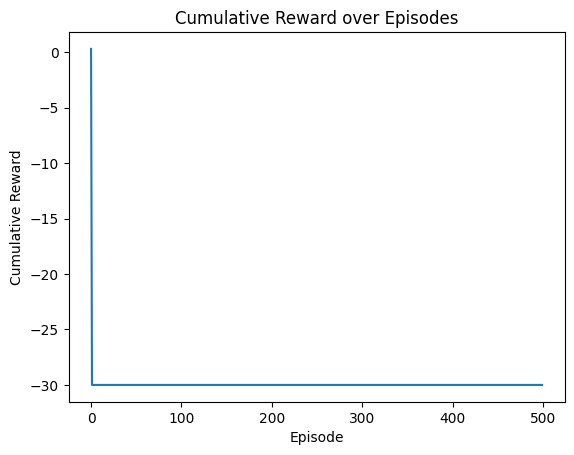

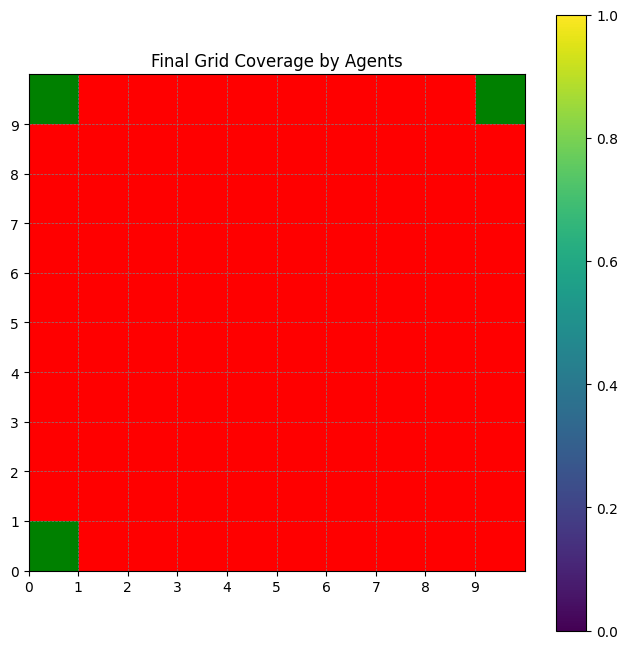

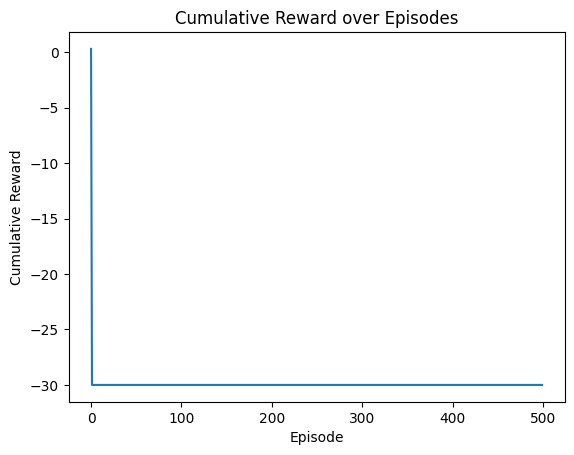

Agent 0 cumulative reward: -9.99999999999998
Agent 1 cumulative reward: -9.99999999999998
Agent 2 cumulative reward: -9.99999999999998


In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Define constants
GRID_SIZE = 10
NUM_AGENTS = 3
EPISODES = 500
MAX_STEPS = 100

# DQN Hyperparameters
STATE_DIM = GRID_SIZE * GRID_SIZE  # Flattened grid
ACTION_DIM = 5  # Up, down, left, right, halt
MEMORY_CAPACITY = 10000
BATCH_SIZE = 64
LEARNING_RATE = 0.001
GAMMA = 0.9
EPSILON = 1
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.05
UPDATE_TARGET = 10

# Rewards
REWARD_NEW_CELL = 1
REWARD_ILLEGAL = -0.5
REWARD_REVISIT = -0.05
REWARD_STAY = -0.1
REWARD_COMPLETE_COVERAGE = 200

# Actions: up, down, left, right, stay
actions = ((0, 1), (0, -1), (-1, 0), (1, 0), (0, 0))
agent_colors = ['red', 'green', 'blue']

# DQN Model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()
        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.out = nn.Linear(h1_nodes, out_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.out(x)
        return x

# Replay Memory
class ReplayMemory():
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Agent Class
class Agent():
    def __init__(self, start_pos, agent_id):
        self.position = start_pos
        self.agent_id = agent_id
        self.cumulative_reward = 0

    def reset(self, start_pos):
        self.position = start_pos
        self.cumulative_reward = 0

    def move(self, action):
        dx = 0
        dy = 0
        try:
            dx, dy = actions[action]
        except ValueError:
            pass  # do nothing!
        x, y = self.position
        new_x = max(0, min(GRID_SIZE - 1, x + dx))
        new_y = max(0, min(GRID_SIZE - 1, y + dy))
        self.position = (new_x, new_y)
        return self.position

# State Representation
def get_state(agent, visited_cells):
    state = visited_cells.flatten()
    return torch.tensor(state, dtype=torch.float32).unsqueeze(0)

loss_fun = nn.MSELoss()
optimizer = None

# Training setup, creating ploicy network and target network
dqn = DQN(STATE_DIM, STATE_DIM, ACTION_DIM)
target_dqn = DQN(STATE_DIM, STATE_DIM, ACTION_DIM)
target_dqn.load_state_dict(dqn.state_dict())
target_dqn.eval()

optimizer = optim.Adam(dqn.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_CAPACITY)

cumulative_rewards = []

step_count = 0

# Training Loop
for episode in range(EPISODES):
    agents = [Agent((0, 0), 0), Agent((0, 9), 1), Agent((9, 0), 2)]
    visited_cells = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)  # Track visit status per cell
    episode_reward = 0

    for step in range(MAX_STEPS):
        for agent in agents:
            state = get_state(agent, visited_cells)
            
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < EPSILON:
                action = random.randint(0, 4)
            else:
                with torch.no_grad():
                    action = torch.argmax(dqn(state)).item()

            # Take action and observe reward
            x, y = agent.position
            new_x, new_y = agent.move(action)
            reward = (REWARD_STAY if (new_x, new_y) == (x, y) else
                      REWARD_NEW_CELL if visited_cells[new_x, new_y] == 0 else
                      REWARD_REVISIT )
            visited_cells[new_x, new_y] = 1
            next_state = get_state(agent, visited_cells)
            done = step == MAX_STEPS - 1

            # Store transition
            memory.push((state, action, reward, next_state, done))

            # Update cumulative reward
            agent.cumulative_reward += reward
            episode_reward += reward

            # Train DQN
            if len(memory) >= BATCH_SIZE:
                transitions = memory.sample(BATCH_SIZE)
                batch = list(zip(*transitions))
                states = torch.cat(batch[0])
                actions = torch.tensor(batch[1]).unsqueeze(1)
                rewards = torch.tensor(batch[2], dtype=torch.float32)
                next_states = torch.cat(batch[3])
                dones = torch.tensor(batch[4], dtype=torch.float32)

                q_values = dqn(states).gather(1, actions).squeeze()
                with torch.no_grad():
                    max_next_q_values = target_dqn(next_states).max(1)[0]
                targets = rewards + GAMMA * max_next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network
        if episode % UPDATE_TARGET == 0:
            target_dqn.load_state_dict(dqn.state_dict())

    # Decay epsilon
    if EPSILON > EPSILON_MIN:
        EPSILON *= EPSILON_DECAY

    cumulative_rewards.append(episode_reward)

    if (episode + 1) % 50 == 0:
        print(f"Episode {episode + 1}/{EPISODES}, Reward: {episode_reward}")

# Visualization
plt.figure()
plt.plot(cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward over Episodes")
plt.show()

# Final Visualization
plt.figure(figsize=(8, 8))
final_grid = np.zeros((GRID_SIZE, GRID_SIZE, 3))

# Assign colors based on which agent last covered each cell
for x in range(GRID_SIZE):
    for y in range(GRID_SIZE):
        if visited_cells[x, y] != -1:  # Only color if a cell was covered
            agent_id = visited_cells[x, y]
            final_grid[x, y] = mcolors.to_rgb(agent_colors[agent_id])

# Plot the grid with colors for each agent
plt.imshow(final_grid, cmap='viridis', extent=[0, GRID_SIZE, 0, GRID_SIZE])
plt.colorbar()
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
plt.xticks(range(GRID_SIZE))
plt.yticks(range(GRID_SIZE))
plt.title("Final Grid Coverage by Agents")
plt.show()

# Display cumulative rewards over episodes
plt.figure()
plt.plot(cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward over Episodes")
plt.show()

# Print cumulative reward for each agent
for agent in agents:
    print(f"Agent {agent.agent_id} cumulative reward: {agent.cumulative_reward}")


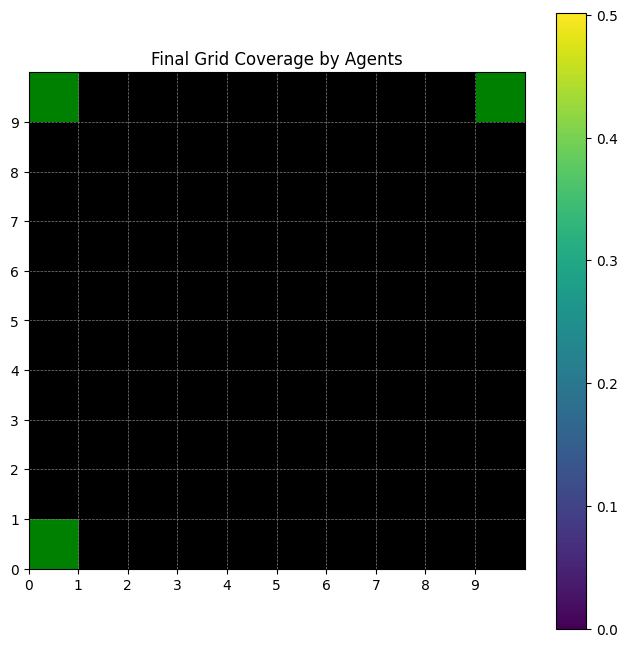

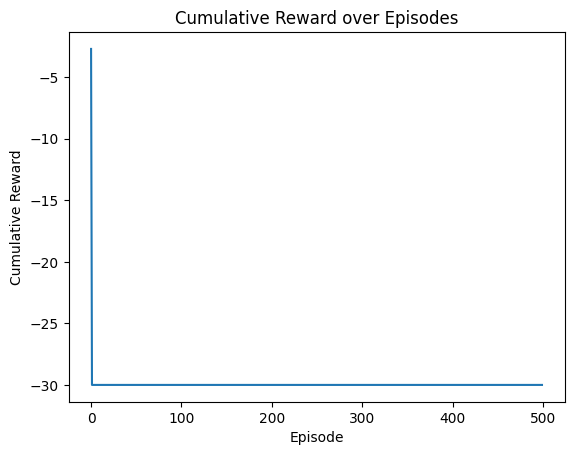

Agent 0 cumulative reward: -9.99999999999998
Agent 1 cumulative reward: -9.99999999999998
Agent 2 cumulative reward: -9.99999999999998


In [5]:
# Final Visualization
plt.figure(figsize=(8, 8))
final_grid = np.zeros((GRID_SIZE, GRID_SIZE, 3))

# Assign colors based on which agent last covered each cell
for x in range(GRID_SIZE):
    for y in range(GRID_SIZE):
        if visited_cells[x, y] == 1:  # Only color if a cell was covered
            agent_id = visited_cells[x, y]
            final_grid[x, y] = mcolors.to_rgb(agent_colors[agent_id])

# Plot the grid with colors for each agent
plt.imshow(final_grid, cmap='viridis', extent=[0, GRID_SIZE, 0, GRID_SIZE])
plt.colorbar()
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
plt.xticks(range(GRID_SIZE))
plt.yticks(range(GRID_SIZE))
plt.title("Final Grid Coverage by Agents")
plt.show()

# Display cumulative rewards over episodes
plt.figure()
plt.plot(cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward over Episodes")
plt.show()

# Print cumulative reward for each agent
for agent in agents:
    print(f"Agent {agent.agent_id} cumulative reward: {agent.cumulative_reward}")